# Quantum Hamiltonians simulations

In [4]:
import numpy as np
import scipy
import matplotlib as mpl

from multiprocessing import Pool


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map as tqdm_parallel
from functools import reduce
from copy import copy
import qutip as qt

%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=3, linewidth=300)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=12)

## Initial state creation

How to represent the initial state:

- Naive approach: initial state for $N$ time bins and $k$ photons is a system of $N$ coupled $(k+1)$-qudits.
- Better approach: ponomarev indexing

## Ponomarev indexing

In [5]:
def ponomarev_index(N, M):
    '''Computes 𝒩_N^M for N bosons and M sites'''
    return scipy.special.comb(N + M - 1, N, exact=True)

def fock_to_ponomarev(sites_list, N, M):
    '''Converts a basis vector of the fock state (m_1 m_2 m_3 ... m_M) into Ponomarev form'''
    # Convert the occupancy to a mi >= mj array for i<j, e.g. 103020 -> 553331
    mj_list = []
    for site_index, site_occupancy in enumerate(sites_list):
        # We need to 1-index here
        for _ in range(site_occupancy):
            mj_list.append(site_index + 1)
    mj_list = sorted(mj_list, reverse=True)
    # print(f"{mj_list=}")
    label = 1
    for i, mj in enumerate(mj_list):
        # print(i+1, M-mj, ponomarev_index(i + 1, M - mj))
        # print(f"mj={i+1}, {M-mj=}, index={ponomarev_index(i + 1, M - mj)}")
        label += ponomarev_index(i + 1, M - mj)
    return label

def ponomarev_to_fock(index, N, M):
    # find the largest 𝒩_N^m < nβ
    def find_largest_ponomarev_index_smaller_than(nβ, n):
        max_index = ponomarev_index(n, 1)
        # Takes care of 0 edge case
        # if max_index >= nβ:
        #     return max_index, 1
        # Loops to find the largest mn
        for m in range(1, M + 1):
            if ponomarev_index(n, m) < nβ:
                max_index = ponomarev_index(n, m)
            else:
                return max_index, m - 1
        raise RuntimeError("Index not found! (Shouldn't be here)")
        # i = 1
        # max_index = ponomarev_index(n, 1)
        # while max_index < nβ:
        #     i += 1
        #     max_index = ponomarev_index(n, i)
        # return max_index, i
    
    mj_list = []
    nβ = index
    for n in range(N, 0, -1):
        max_index, mn = find_largest_ponomarev_index_smaller_than(nβ, n)
        # print(f"{max_index=}, {mn=}, {nβ=}, {n=}")
        mj_list.append(M - mn)
        nβ = nβ - max_index
    # print(f"{mj_list=}")
        
    # Convert mj array back to a Fock occupancy list
    fock_list = [0] * M
    for mj in mj_list:
        fock_list[mj-1] += 1 # convert back to 0-indexing
        
    return fock_list

In [6]:
# Check that these functions invert themselves
def test_fock_ponomarev_inverse(N, M):
    values_checked = 0
    for index in range(1, ponomarev_index(N, M) + 1):
        fock = ponomarev_to_fock(index, N, M)
        if fock_to_ponomarev(fock, N, M) != index:
            raise ValueError(f"{ponomarev_to_fock(index, N, M)=}, but {fock_to_ponomarev(fock, N, M)=} !")
        else:
            values_checked += 1
    print(f"All {values_checked} values are invertable for {N=}, {M=}.")
            
for n in range(6+1):
    for m in range(6+1):
        test_fock_ponomarev_inverse(n,m)

All 0 values are invertable for N=0, M=0.
All 1 values are invertable for N=0, M=1.
All 1 values are invertable for N=0, M=2.
All 1 values are invertable for N=0, M=3.
All 1 values are invertable for N=0, M=4.
All 1 values are invertable for N=0, M=5.
All 1 values are invertable for N=0, M=6.
All 0 values are invertable for N=1, M=0.
All 1 values are invertable for N=1, M=1.
All 2 values are invertable for N=1, M=2.
All 3 values are invertable for N=1, M=3.
All 4 values are invertable for N=1, M=4.
All 5 values are invertable for N=1, M=5.
All 6 values are invertable for N=1, M=6.
All 0 values are invertable for N=2, M=0.
All 1 values are invertable for N=2, M=1.
All 3 values are invertable for N=2, M=2.
All 6 values are invertable for N=2, M=3.
All 10 values are invertable for N=2, M=4.
All 15 values are invertable for N=2, M=5.
All 21 values are invertable for N=2, M=6.
All 0 values are invertable for N=3, M=0.
All 1 values are invertable for N=3, M=1.
All 4 values are invertable for

In [155]:
ponomarev_to_fock(462,6,6)

max_index=210, mn=5, nβ=462, n=6
max_index=126, mn=5, nβ=252, n=5
max_index=70, mn=5, nβ=126, n=4
max_index=35, mn=5, nβ=56, n=3
max_index=15, mn=5, nβ=21, n=2
max_index=5, mn=5, nβ=6, n=1
mj_list=[1, 1, 1, 1, 1, 1]


[6, 0, 0, 0, 0, 0]

In [343]:
fock_to_ponomarev([1,0,2,0,2],5,5)

66

In [95]:
fock_to_ponomarev([1,0,3,0,2,0], 6, 6)

[5, 5, 3, 3, 3, 1]
mj=1, M-mj=1, index=1
mj=2, M-mj=1, index=1
mj=3, M-mj=3, index=10
mj=4, M-mj=3, index=15
mj=5, M-mj=3, index=21
mj=6, M-mj=5, index=210


258

In [106]:
fock_to_ponomarev([2,1,1,0,2,0], 6, 6)

[5, 5, 3, 2, 1, 1]
mj=1, M-mj=1, index=1
mj=2, M-mj=1, index=1
mj=3, M-mj=3, index=10
mj=4, M-mj=4, index=35
mj=5, M-mj=5, index=126
mj=6, M-mj=5, index=210


383

In [131]:
fock_to_ponomarev([6,0,0,0,0,0], 6, 6)

462

In [218]:
ponomarev_index(2,100)

5050

In [216]:
3**100

515377520732011331036461129765621272702107522001

In [233]:
np.real((qt.basis(2,0) + qt.basis(2,1)).full()).tolist()

[[1.0], [1.0]]

In [183]:
state = create_initial_state_all_photons_one_bin(2, 2, full_bin_index=0, include_register=False)
state

Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]

In [204]:
# qt.tensor(qt.destroy(3), qt.qeye(3))
qt.destroy(3).full()[0,1]

(1+0j)

In [190]:
n=3
a1 = qt.tensor([qt.destroy(n), qt.qeye(n)]) # register annihilator
a2 = qt.tensor([qt.qeye(n), qt.destroy(n)]) # register annihilator
θ = np.pi/2
ϕ = 0
(1j * θ / 2 * (np.exp(-1j*ϕ) * a1.dag() * a2 + np.exp(1j*ϕ) * a2.dag() * a1)).expm()

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.70710678+0.j          0.        +0.j
   0.        +0.70710678j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.5       +0.j
   0.        +0.j          0.        +0.70710678j  0.        +0.j
  -0.5       +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.70710678j  0.        +0.j
   0.70710678+0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.70710678j
 

## QuTiP state and operator conversion into Ponomarev indexing

In [7]:
def qt_tensor_to_fock(tensor_state):
    '''Converts a many-body tensor state into a combination of up to D^N fock states.
    Example: [1 1 1 1] ==> 1/2(|11>+|10>+|01>+|00>)'''
    

def qt_fock_to_ponomarev(fock_state, N, M):
    '''Converts a qutip state or list of the form (m_1 m_2 m_3 ... m_M) into Ponomarev form'''
    
    
    
    # TODO FINISH THIS!!!!!!
    dim = ponomarev_index(N, M) + 1
    index = fock_to_ponomarev(fock_state, N, M)
    return qt.basis(dim, index)
    
    data = np.zeros((dim, dim), dtype=complex)
    
    if type(fock_state) is qt.Qobj:
        pass
        

def qt_ponomarev_to_fock(index, N, M):
    pass

In [10]:
def get_n_d(state):
    fock_cutoff = state.dims[0][0]
    N = fock_cutoff - 1 # number of photons
    time_bins_plus_register = len(state.dims[0])
    D = time_bins_plus_register - 1 # number of time bins in the storage ring
    return N, D

def annihilator_for_site(site_index, total_sites, fock, use_ponomarev=True):
    '''Returns the annihilator I ⊗ I ⊗ ... ⊗ a ⊗ ... ⊗ I ⊗ I for a given site'''
    assert site_index <= total_sites - 1 and site_index >=0, "Site must be in range [0,total_sites)"
    if use_ponomarev:
        num_bosons = fock - 1
        return _get_ponomarev_annihilator(site_index, total_sites, num_bosons)
    else:
        return qt.tensor([qt.qeye(fock) for _ in range(site_index)] + [qt.destroy(fock)] + [qt.qeye(fock) for _ in range(total_sites - site_index - 1)])

# def get_annihilator_index(index, num_operators, fock):
#     '''Returns I ⊗ I ⊗ ... ⊗ a.dag() ⊗ ... ⊗ I ⊗ I'''
#     assert index <= num_operators - 1 and index >=0, "Time bin must be in range [0,D)"
#     return qt.tensor([qt.qeye(fock) for _ in range(index)] + [qt.destroy(fock)] + [qt.qeye(fock) for _ in range(num_operators - index - 1)])

def get_register_annihilator(n_time_bins, n_photons, fock_cutoff=None):
    '''Returns the register annihilation operator I ⊗ I ⊗ ... ⊗ I ⊗ a.dag()'''
    fock = n_photons + 1 if fock_cutoff is None else fock_cutoff
    return qt.tensor([qt.qeye(fock) for _ in range(n_time_bins)] + [qt.destroy(fock)])

def get_bin_annihilator(n_time_bins, n_photons, time_bin_index, include_register=True, fock_cutoff=None):
    '''Returns I ⊗ I ⊗ ... ⊗ a.dag() ⊗ ... ⊗ I ⊗ I'''
    assert time_bin_index <= n_time_bins - 1, "Time bin must be in range [0,D)"
    fock = n_photons + 1 if fock_cutoff is None else fock_cutoff
    storage_op = [qt.qeye(fock) for _ in range(time_bin_index)] + [qt.destroy(fock)] + [qt.qeye(fock) for _ in range(n_time_bins - time_bin_index - 1)]
    if include_register:
        register_op = [qt.qeye(fock)]
        return qt.tensor(storage_op + register_op)
    else:
        return qt.tensor(storage_op)

In [11]:
_ANNIHILATOR_CACHE = {}
def _get_ponomarev_annihilator(site_index, total_sites, num_bosons):
    if (site_index, total_sites, num_bosons) in _ANNIHILATOR_CACHE:
        return _ANNIHILATOR_CACHE[(site_index, total_sites, num_bosons)]
    N = num_bosons  # N bosons
    M = total_sites  # M sites
    
    dim = ponomarev_index(N, M) + 1
    data = np.zeros((dim, dim), dtype=complex)
    
    for index in range(1, dim):
        fock = ponomarev_to_fock(index, N, M)
        n_level = fock[site_index]
        if n_level > 0:
            from_index = index
            to_fock = copy(fock)            
            to_fock[site_index] -= 1
            to_index = fock_to_ponomarev(to_fock, N, M)
            data[to_index, from_index] = np.sqrt(n_level)  
            
    op = qt.Qobj(data)
    _ANNIHILATOR_CACHE[(site_index, total_sites, num_bosons)] = op
    
    return op



# Check that these annihilators behave as expected
def test_ponomarev_annihilator(total_sites, num_bosons):
    N = num_bosons  # N bosons
    M = total_sites  # M sites
    dim = ponomarev_index(N, M) + 1

    values_checked = 0
    for index in range(1, dim):
        fock = ponomarev_to_fock(index, N, M)
        
        for site_index in range(total_sites):
            n_level = fock[site_index]
            
            qt_fock = qt.basis([num_bosons+1] * total_sites, fock)
            qt_a = annihilator_for_site(site_index, total_sites, num_bosons+1, use_ponomarev=False)
            qt_fock_new = qt_a * qt_fock
            
            qt_pn = qt.basis(dim, index)
            qt_pn_a = _get_ponomarev_annihilator(site_index, total_sites, num_bosons)
            qt_pn_new = qt_pn_a * qt_pn
            
            # Check that amplitude is as expected
            assert qt_pn_new.norm() == np.sqrt(n_level)
            # Check that fock has reduced a state
            fock_new = copy(fock)
            fock_new[site_index] -= 1
            qt_pn_new_expected = qt.basis(dim, fock_to_ponomarev(fock_new, N, M))
            if qt_pn_new.norm() != 0:
                assert qt_pn_new.unit() == qt_pn_new_expected.unit()
            # Check that a.dag puts it back in original state
            assert qt_pn_a.dag() * qt_pn_new == n_level * qt_pn
            values_checked += 1
    print(f"Annihilators behave correctly for all {values_checked} test cases for {N=}, {M=}.")

for N in range(4+1):
    for M in range(4+1):
        test_ponomarev_annihilator(N, M) 

Annihilators behave correctly for all 0 test cases for N=0, M=0.
Annihilators behave correctly for all 0 test cases for N=1, M=0.
Annihilators behave correctly for all 0 test cases for N=2, M=0.
Annihilators behave correctly for all 0 test cases for N=3, M=0.
Annihilators behave correctly for all 0 test cases for N=4, M=0.
Annihilators behave correctly for all 1 test cases for N=0, M=1.
Annihilators behave correctly for all 1 test cases for N=1, M=1.
Annihilators behave correctly for all 1 test cases for N=2, M=1.
Annihilators behave correctly for all 1 test cases for N=3, M=1.
Annihilators behave correctly for all 1 test cases for N=4, M=1.
Annihilators behave correctly for all 2 test cases for N=0, M=2.
Annihilators behave correctly for all 4 test cases for N=1, M=2.
Annihilators behave correctly for all 6 test cases for N=2, M=2.
Annihilators behave correctly for all 8 test cases for N=3, M=2.
Annihilators behave correctly for all 10 test cases for N=4, M=2.
Annihilators behave corr

In [12]:
# def create_initial_state_one_photon_per_bin(n_time_bins_and_photons):
#     '''Creates an initial state corresponding to n photons, one in each of d time bins'''
#     # TODO: Fock dimension cutoff
#     d = n_time_bins_and_photons
#     n = n_time_bins_and_photons
#     storage_state = [qt.create(n+1) * qt.basis(n+1, 0) for _ in range(d)]
#     register_state = [qt.basis(n+1, 0)]
#     return qt.tensor(storage_state + register_state)

def create_initial_state_all_photons_one_bin(n_time_bins, n_photons, full_bin_index=0, fock_cutoff=None, include_register=True, use_ponomarev=False):
    '''Creates an initial state correspoding to n photons all contained in one time bin'''
    if use_ponomarev:
        fock_list = [0] * n_time_bins
        fock_list[full_bin_index] = n_photons
        return qt_fock_to_ponomarev(fock_list, n_photons, n_time_bins)
    else:
        d = n_time_bins
        n = n_photons
        if fock_cutoff is None:
            fock = n+1
        else:
            fock = fock_cutoff
        assert full_bin_index <= n_time_bins - 1 and full_bin_index >= 0, "Time bin must be in range [0,D)"
        storage_state = [qt.basis(fock, 0) for _ in range(full_bin_index)] + [(qt.create(fock) ** n * qt.basis(fock, 0)).unit()] + [qt.basis(fock, 0) for _ in range(n_time_bins - full_bin_index - 1)]
        if include_register:
            register_state = [qt.basis(fock, 0)]
            return qt.tensor(storage_state + register_state)
        else:
            return qt.tensor(storage_state)

## MZI and register operations

In [14]:
def mzi_register(θ, ϕ, time_bin, n=None, d=None):
    '''Operation corresponding to passing a time bin through the register MZI'''
    fock = n+1
    a1 = get_register_annihilator(d, n, fock_cutoff=fock) # register annihilator
    a2 = get_bin_annihilator(d, n, time_bin_index=time_bin, fock_cutoff=fock) # bin annihilator
    return (1j * θ / 2 * (np.exp(-1j*ϕ) * a1.dag() * a2 + np.exp(1j*ϕ) * a2.dag() * a1)).expm()

mzi_register(np.pi, np.pi/2, time_bin=0, n=1, d=1)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]]

In [17]:
def swap_bin_into_register(time_bin, n, d):
    '''Swaps a photon pulse from a storage bin into the register, maintaining the phase'''
    return mzi_register(np.pi, np.pi/2, time_bin=time_bin, n=n, d=d)

def swap_bin_from_register(time_bin, n, d):
    '''Swaps a photon pulse from the register into a storage bin, maintaining the phase'''
    return mzi_register(np.pi, -np.pi/2, time_bin=time_bin, n=n, d=d)

def interact_register_bin(time_bin, κ, α, n, d):
    '''Applies exp(i κ(e^-iα a1+ a2 + e^iα a2+ a1)) between the register and a time bin'''
    θ = κ * 2
    ϕ = α
    return mzi_register(θ, ϕ, n, d, time_bin=time_bin)

def interact_bin_bin(bin1, bin2, κ, α, n, d):
    '''Transfers a bin to the register, applies exp(i κ(e^-iα a1+ a2 + e^iα a2+ a1))
    between the register and the time bin, and then returns the first bin to its original space'''
    θ = κ * 2
    ϕ = α
    return swap_bin_from_register(bin1, n=N, d=D) * mzi_register(θ, ϕ, bin2, n=N, d=D) * swap_bin_into_register(bin1, n=N, d=D)

## Simulations

In [18]:
def get_photon_occupancies(state, n_time_bins=None, n_photons=None, exclude_register=False, use_ponomarev=False):
    '''Returns a D+1 length list of photon number expectation values for each 
    time bin plus the register (last element)'''
    if use_ponomarev:
        # Get occupancies of the storage bins
        expectations = []
        for site_index in range(n_time_bins):
            a = annihilator_for_site(site_index=site_index, total_sites=n_time_bins, fock=n_photons+1, use_ponomarev=True)
            expectations.append(qt.expect(a.dag()*a, state))
        return expectations
    
    else:
        expectations = []
        N, D = get_n_d(state)
        # Get occupancies of the storage bins
        for i in range(D):
            a=get_bin_annihilator(D, N, time_bin_index=i)
            expectations.append(qt.expect(a.dag()*a, state))
        # Append the register expectations
        if not exclude_register:
            a = get_register_annihilator(D, N)
            expectations.append(qt.expect(a.dag()*a, state))
        return expectations

In [19]:
N=1
D=9
state = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, use_ponomarev=True)
get_photon_occupancies(state, n_time_bins=D, n_photons=N, use_ponomarev=True)

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [20]:
def construct_BHH_propagator_2d_grid(nx, ny, toroidal=False,
                                     n=N, d=D,
                                     κ=0.1, α=0,
                                     fock=N+1, 
                                     μ=None, U=None,
                                     include_coupling=True, 
                                     include_chemical_potential=True, 
                                     include_onsite_interaction=True):
    num_nodes = nx * ny
    assert num_nodes == D
    nodes = list(range(num_nodes))
    nodes_xy = np.array(nodes).reshape((ny, nx))
    operations = []
    for y in range(ny):
        for x in range(nx):
            if x < nx-1 or toroidal: # we're not at the right edge 
                operations.append(interact_bin_bin(bin1=nodes_xy[y, x], bin2=nodes_xy[y, (x+1) % nx], κ=κ, α=α, n=N, d=D))
            if y < ny-1 or toroidal: # we're not at the bottom edge
                operations.append(interact_bin_bin(bin1=nodes_xy[(y+1) % ny, x], bin2=nodes_xy[y, x], κ=κ, α=α, n=N, d=D))
                
    # Compute the propagator for one iteration
    return reduce(lambda U1, U2: U2 * U1, operations) # left-multiplication

In [21]:
def make_BH_Hamiltonian(nodes, edges, fock=N+1, μ=None, U=None,
                        include_coupling=True, 
                        include_chemical_potential=True, 
                        include_onsite_interaction=True,
                        use_ponomarev=False,
                        display_progress=False):
    '''
    Returns the actual Bose-Hubbard Hamiltonian for a list of lattice sites and a list of couplings between sites
    Args:
        nodes: a list of node indices, e.g. [1,2,3,4]
        edges: a list of couplings between edges with coupling constants and phases, e.g. [((1,2), 0.1, np.pi), ((1,3), 0.15, np.pi/2), ...]
    '''
    if use_ponomarev:
        dim = ponomarev_index(fock-1, len(nodes)) + 1
        H = qt.qzero(dim)
    else:
        H = qt.tensor([qt.qzero(fock) for _ in nodes])
    
    if include_coupling:
        iterator = tqdm if display_progress else lambda x: x
        for ((node1, node2), κ, α) in iterator(edges):
            a1 = annihilator_for_site(site_index=node1, total_sites=len(nodes), fock=fock, use_ponomarev=use_ponomarev)
            a2 = annihilator_for_site(site_index=node2, total_sites=len(nodes), fock=fock, use_ponomarev=use_ponomarev)
            # a1 = get_annihilator_index(index=node1, num_operators=len(nodes), fock=fock)
            # a2 = get_annihilator_index(index=node2, num_operators=len(nodes), fock=fock)
            H += -1 * κ * (np.exp(-1j * α) * a1.dag() * a2 + np.exp(1j * α) * a2.dag() * a1)
            
    if include_chemical_potential:
        for node in nodes:
            a = annihilator_for_site(site_index=node, total_sites=len(nodes), fock=fock, use_ponomarev=use_ponomarev)
            # a = get_annihilator_index(index=node, num_operators=len(nodes), fock=fock)
            H += -1 * μ * a.dag() * a
            
    if include_onsite_interaction:
        for node in nodes:
            a = annihilator_for_site(site_index=node, total_sites=len(nodes), fock=fock, use_ponomarev=use_ponomarev)
            # a = get_annihilator_index(index=node, num_operators=len(nodes), fock=fock)
            H += U * a.dag() * a * a * a.dag()
            
    return H


def BHH_2d_grid(nx, ny, toroidal=False,
                κ=0.1,
                fock=N+1, 
                μ=None, U=None,
                include_coupling=True, 
                include_chemical_potential=True, 
                include_onsite_interaction=True,
                use_ponomarev=False,
                display_progress=False):
    num_nodes = nx * ny
    nodes = list(range(num_nodes))
    nodes_xy = np.array(nodes).reshape((ny, nx))
    edges = []
    for y in range(ny):
        for x in range(nx):
            if x < nx-1: # we're not at the right edge
                edges.append(((nodes_xy[y,x], nodes_xy[y,x+1]), κ, 0))
            elif toroidal:
                edges.append(((nodes_xy[y,x], nodes_xy[y, (x+1) % nx]), κ, 0))
            if y < ny-1: # we're not at the bottom edge
                edges.append(((nodes_xy[y,x], nodes_xy[y+1,x]), κ, 0))
            elif toroidal:
                edges.append(((nodes_xy[y,x], nodes_xy[(y+1) % ny, x]), κ, 0))
    return make_BH_Hamiltonian(nodes, edges, fock=fock, μ=μ, U=U, 
                               include_coupling=include_coupling, 
                               include_chemical_potential=include_chemical_potential, 
                               include_onsite_interaction=include_onsite_interaction,
                               use_ponomarev=use_ponomarev,
                               display_progress=display_progress)


def BHH_1d_line(num_nodes, toroidal=False,
                κ=0.1,
                fock=N+1, 
                μ=None, U=None,
                include_coupling=True, 
                include_chemical_potential=True, 
                include_onsite_interaction=True,
                use_ponomarev=False,
                display_progress=False):
    nodes = list(range(num_nodes))
    edges = []
    for i in range(num_nodes):
        if i < num_nodes-1 or toroidal: # we're not at the right edge
            edges.append(((nodes[i], nodes[(i+1) % num_nodes]), κ, 0))
    return make_BH_Hamiltonian(nodes, edges, fock=fock, μ=μ, U=U, 
                               include_coupling=include_coupling, 
                               include_chemical_potential=include_chemical_potential, 
                               include_onsite_interaction=include_onsite_interaction,
                               use_ponomarev=use_ponomarev,
                               display_progress=display_progress)

## Visualization

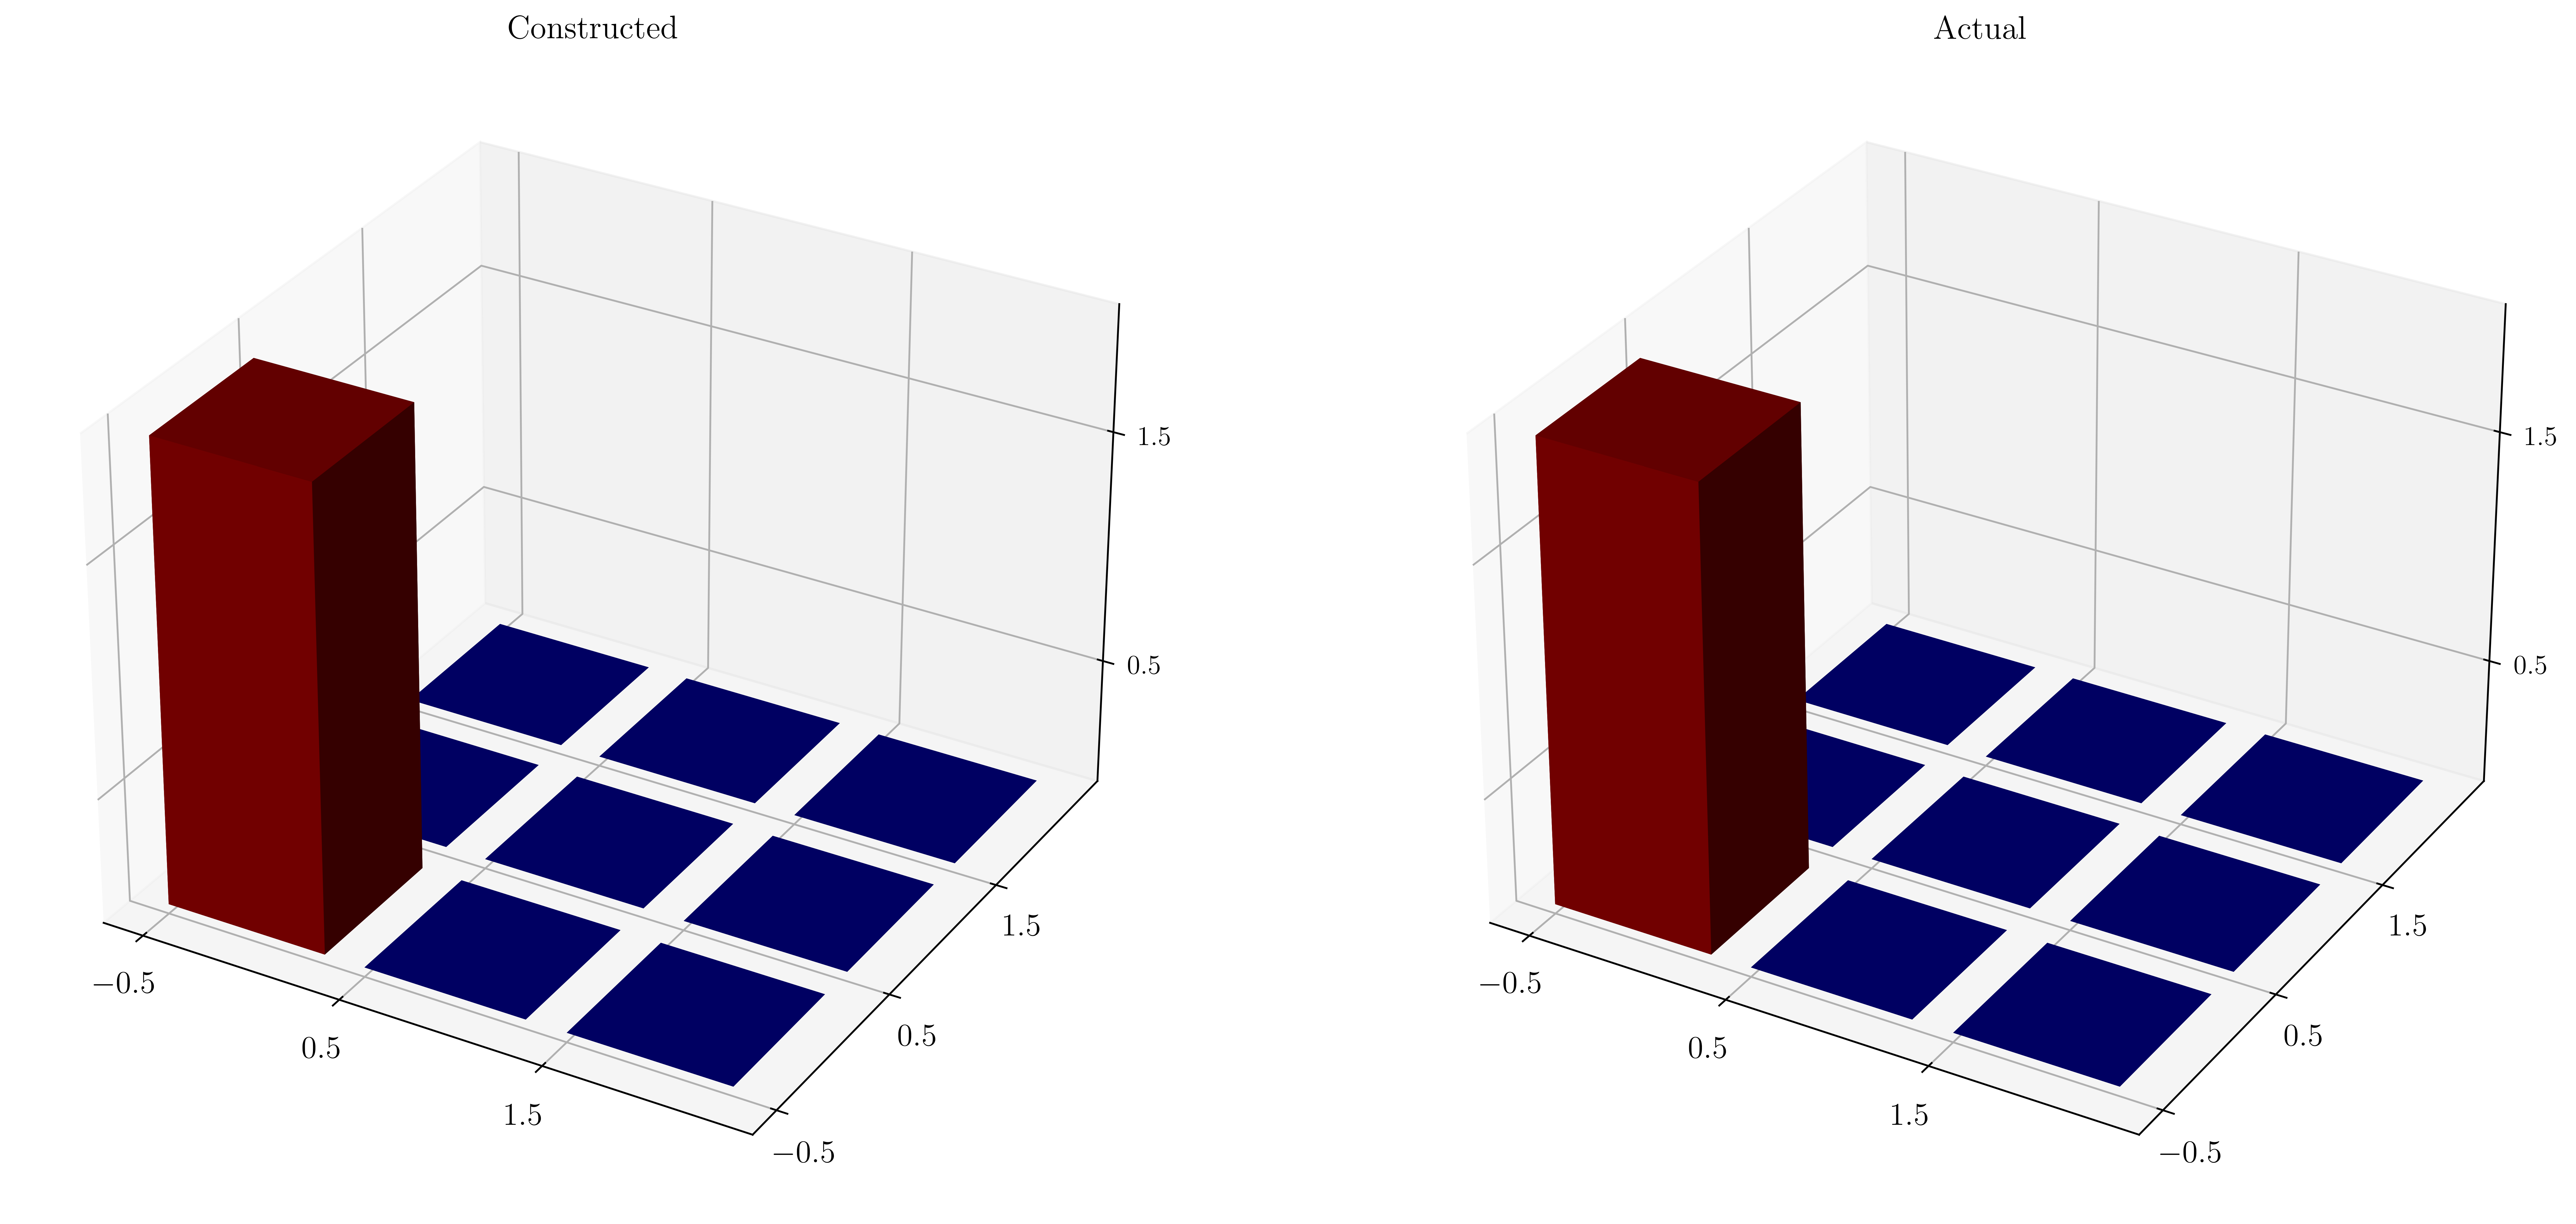

In [22]:
def _axes3D(fig, *args, **kwargs):
    ax = Axes3D(fig, *args, auto_add_to_figure=False, **kwargs)
    return fig.add_axes(ax)

def plot_occupancies_2d_grid(state_constructed, state_actual, n_time_bins=None, n_photons=None, nx=3, ny=3, limits=None):
    fig = plt.figure(figsize=(20,10))
    # ax = _axes3D(fig, azim=-35, elev=35)

    # ax1 = Axes3D(fig, *args, auto_add_to_figure=False, **kwargs)
    # ax2 = Axes3D(fig, *args, auto_add_to_figure=False, **kwargs)

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
    photon_occupancies_constructed = np.array(get_photon_occupancies(state_constructed, n_time_bins=n_time_bins, n_photons=n_photons, exclude_register=True)).reshape(ny,nx)
    qt.matrix_histogram(photon_occupancies_constructed,fig=fig, ax=ax1, title="Constructed", colorbar=False, limits=limits)
    
    photon_occupancies_actual = np.array(get_photon_occupancies(state_actual, n_time_bins=n_time_bins, n_photons=n_photons)).reshape(ny,nx)
    qt.matrix_histogram(photon_occupancies_actual,fig=fig, ax=ax2, title="Actual", colorbar=False, limits=limits)
    
    return fig
        
state_constructed = create_initial_state_all_photons_one_bin(n_time_bins=9, n_photons=2, full_bin_index=0, include_register=True)
state_actual = create_initial_state_all_photons_one_bin(n_time_bins=9, n_photons=2, full_bin_index=0, include_register=False)

fig = plot_occupancies_2d_grid(state_constructed, state_actual, limits=[0,2])
plt.show()

In [344]:
# Compare ponomarev vs non-ponomarev evolutions
N = 1
D = 9
nx = int(np.sqrt(D))
ny = int(np.sqrt(D))
fock = N+1

κ = 0.01
tmax = 1000

# Actual evolution
state_actual = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=False)
H = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, include_chemical_potential=False, include_onsite_interaction=False)
# state_actual_evolved = (-1j * H * t).expm() * state_actual

# Constructed evolution
state_pn = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=True, use_ponomarev=True)
H_pn = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, include_chemical_potential=False, include_onsite_interaction=False, use_ponomarev=True)
# state_pn_evolved = (-1j * H_pn * t).expm() * state_pn

for t in tqdm(range(0,tmax)):
    state_actual_evolved = (-1j * H * t).expm() * state_actual
    state_pn_evolved = (-1j * H_pn * t).expm() * state_pn
    
    fig = plt.figure(figsize=(20,10))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    photon_occupancies = np.array(get_photon_occupancies(state_actual_evolved, n_time_bins=D, n_photons=N)).reshape(ny,nx)
    qt.matrix_histogram(photon_occupancies,fig=fig, ax=ax1, title="Normal", colorbar=False, limits=[0,N])

    photon_occupancies_pn = np.array(get_photon_occupancies(state_pn_evolved, n_time_bins=D, n_photons=N, use_ponomarev=True)).reshape(ny,nx)
    qt.matrix_histogram(photon_occupancies_pn,fig=fig, ax=ax2, title="Ponomarev", colorbar=False, limits=[0,N])

    fig.text(0.15, 0.8, f"$t={t}, κ={κ}$", fontsize=30)

    title = str(t).zfill(8)
    plt.savefig("frames/evolution_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [340]:
# Compare ponomarev vs non-ponomarev evolutions
N = 2
D = 64
nx = int(np.sqrt(D))
ny = int(np.sqrt(D))
fock = N+1

κ = 0.02
μ = 0.1
U = 0.1
tmax = 1000

# Ponomarev evolution
fock_list = [0] * D
fock_list[0] = N // 2
fock_list[D-1] = N // 2
state_pn = qt_fock_to_ponomarev(fock_list, N, D)

# state_pn = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=True, use_ponomarev=True)
H_pn = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, μ=μ, U=U, include_chemical_potential=True, include_onsite_interaction=True, use_ponomarev=True, display_progress=True)
# state_pn_evolved = (-1j * H_pn * t).expm() * state_pn

for t in tqdm(range(0,tmax)):
    state_pn_evolved = (-1j * H_pn * t).expm() * state_pn
    
    fig = plt.figure(figsize=(10,10))

    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    # ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    photon_occupancies_pn = np.array(get_photon_occupancies(state_pn_evolved, n_time_bins=D, n_photons=N, use_ponomarev=True)).reshape(ny,nx)
    qt.matrix_histogram(photon_occupancies_pn,fig=fig, ax=ax1, title="Ponomarev", colorbar=False, limits=[0,N])

    fig.text(0.15, 0.8, f"$t={t}, κ={κ}$", fontsize=30)

    title = str(t).zfill(8)
    plt.savefig("frames/evolution_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

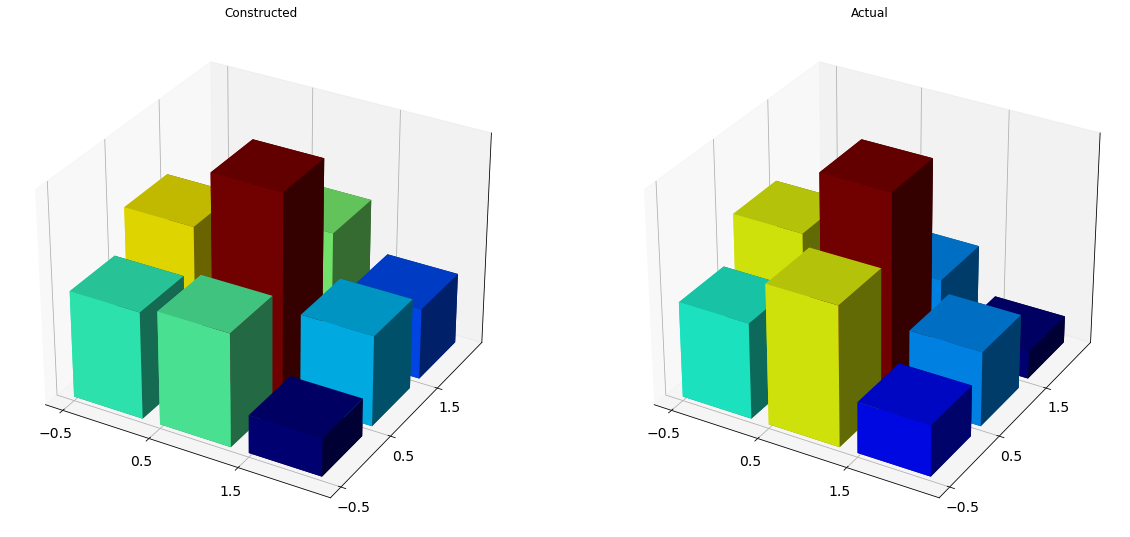

In [29]:
# Evolve the same initial state using constructed and actual evolutions
N = 1
D = 9
nx = int(np.sqrt(D))
ny = int(np.sqrt(D))
fock = N+1

κ = 0.
t = 10

# Actual evolution
state_actual = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=False)
H = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, include_chemical_potential=False, include_onsite_interaction=False)
state_actual_evolved = (-1j * H * t).expm() * state_actual

# Constructed evolution
state_constructed = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=True)
iteration_op = construct_BHH_propagator_2d_grid(nx, ny, toroidal=False, n=N, d=D, κ=κ)
state_constructed_evolved = iteration_op ** t * state_constructed

plot_occupancies_2d_grid(state_constructed_evolved, state_actual_evolved, nx=nx, ny=ny)

## Animation rendering

In [21]:
# Evolve the same initial state using constructed and actual evolutions
N = 1
D = 9
nx = int(np.sqrt(D))
ny = int(np.sqrt(D))
fock = N+1

κ = 0.1
tmax = 100

# Actual evolution
state_actual = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=False)
H = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, include_chemical_potential=False, include_onsite_interaction=False)

# Constructed evolution
state_constructed = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=True)
iteration_op = construct_BHH_propagator_2d_grid(nx, ny, toroidal=False, n=N, d=D, κ=κ)

cumulative_iteration_op = iteration_op ** 0
for t in tqdm(range(0, tmax)):
    state_actual_evolved = (-1j * H * t).expm() * state_actual
    state_constructed_evolved = cumulative_iteration_op * state_constructed
    cumulative_iteration_op *= iteration_op
    # state_constructed_evolved = iteration_op ** t * state_constructed

    fig = plot_occupancies_2d_grid(state_constructed_evolved, state_actual_evolved, nx=nx, ny=ny, limits=[0,N])
    fig.text(0.15, 0.8, f"$t={t}, κ={κ}$", fontsize=30)

    title = str(t).zfill(8)
    plt.savefig("frames/evolution_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]

In [354]:
def hinton(W, xlabels = None, ylabels = None, labelsize = 9, title = None, fig = None, ax = None, cmap = None, color_mode="phase", z_limits=None):

    def _blob(x, y, w, w_min, w_max, area, cmap = None, ax = None):
        """
        Draws a square-shaped blob with the given area (< 1) at
        the given coordinates.
        """
        hs = np.sqrt(area) / 2
        xcorners = np.array([x - hs, x + hs, x + hs, x - hs])
        ycorners = np.array([y - hs, y - hs, y + hs, y + hs])

        handle = ax if ax is not None else plt
        # color = int(256 * (w - w_min) / (w_max - w_min))
        color = (w - w_min) / (w_max - w_min)
        handle.fill(xcorners, ycorners, color = cmap(color))

    if cmap is None:
        cmap = plt.get_cmap('twilight')

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize = (4, 4))

    if not (xlabels or ylabels):
        ax.axis('off')

    ax.axis('equal')
    ax.set_frame_on(False)

    height, width = W.shape
    ax.set(xlim = (0, width), ylim = (0, height))

    max_abs = np.max(np.abs(W))
    scale = 0.7

    for i in range(width):
        for j in range(height):
            x = i + 1 - 0.5
            y = j + 1 - 0.5
            if color_mode == "phase":
                _blob(x, height - y, np.angle(W[i, j]), -np.pi, np.pi,
                      np.abs(W[i, j]) / max_abs * scale, cmap = cmap, ax = ax)
            elif color_mode == "magnitude":
                if z_limits is None:
                    raise ValueError("Need z limits for magnitude shading")
                _blob(x, height - y, np.abs(W[i, j]), z_limits[0], z_limits[1],
                      np.abs(W[i, j]) / max_abs * scale, cmap = cmap, ax = ax)
            else:
                raise ValueError("Expected color_mode = 'phase' or 'magnitude")

    # x axis
    ax.xaxis.set_major_locator(plt.IndexLocator(1, 0.5))
    if xlabels:
        ax.set_xticklabels(xlabels, rotation = 'vertical')
        ax.xaxis.tick_top()
    ax.tick_params(axis = 'x', labelsize = labelsize, pad = 0)
    ax.xaxis.set_ticks_position('none')

    # y axis
    ax.yaxis.set_major_locator(plt.IndexLocator(1, 0.5))
    ax.yaxis.set_ticks_position('none')
    if ylabels:
        ax.set_yticklabels(list(reversed(ylabels)))
    ax.tick_params(axis = 'y', labelsize = labelsize, pad = 0)

    # color axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size = '4%', pad = '2%')
    if color_mode == "phase":
        cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = mpl.colors.Normalize(-np.pi, np.pi), ticks = [])
        cax.text(0.5, 0.0, '$-\pi$', transform = cax.transAxes, va = 'top', ha = 'center')
        cax.text(0.5, 1.0, '$+\pi$', transform = cax.transAxes, va = 'bottom', ha = 'center')
    elif color_mode == "magnitude":
        cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = mpl.colors.Normalize(z_limits[0], z_limits[1]), ticks = [])
        cax.text(0.5, 0.0, str(z_limits[0]), transform = cax.transAxes, va = 'top', ha = 'center')
        cax.text(0.5, 1.0, str(z_limits[1]), transform = cax.transAxes, va = 'bottom', ha = 'center')
    else:
        raise ValueError("Expected color_mode = 'phase' or 'magnitude")

    # Make title in corner
    if title is not None:
        plt.text(-.07, 1.05, title, ha = 'center', va = 'center', fontsize = 22, transform = ax.transAxes)

    return fig, ax

  0%|          | 0/112 [00:00<?, ?it/s]

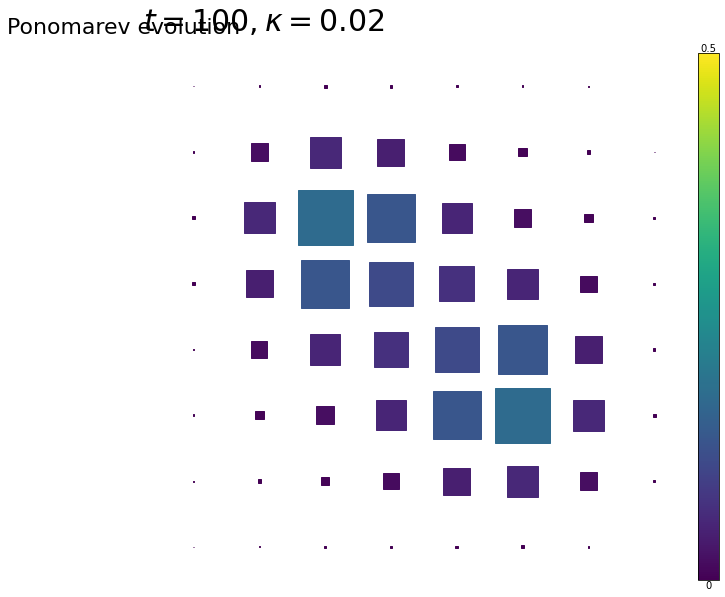

In [358]:
# Compare ponomarev vs non-ponomarev evolutions
N = 2
D = 64
nx = int(np.sqrt(D))
ny = int(np.sqrt(D))
fock = N+1

κ = 0.02
μ = 0.1
U = 0.1
tmax = 1000

# Ponomarev evolution
fock_list = [0] * D
fock_list[0] = N // 2
fock_list[D-1] = N // 2
state_pn = qt_fock_to_ponomarev(fock_list, N, D)

# state_pn = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=True, use_ponomarev=True)
H_pn = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, μ=μ, U=U, include_chemical_potential=True, include_onsite_interaction=True, use_ponomarev=True, display_progress=True)
# state_pn_evolved = (-1j * H_pn * t).expm() * state_pn

# for t in tqdm(range(0,tmax)):

t= 100
state_pn_evolved = (-1j * H_pn * t).expm() * state_pn

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(1, 1, 1)
# ax2 = fig.add_subplot(1, 2, 2, projection='3d')

photon_occupancies_pn = np.array(get_photon_occupancies(state_pn_evolved, n_time_bins=D, n_photons=N, use_ponomarev=True)).reshape(ny,nx)
# qt.matrix_histogram(photon_occupancies_pn,fig=fig, ax=ax1, title="Ponomarev", colorbar=False, limits=[0,N])
hinton(photon_occupancies_pn, xlabels = None, ylabels = None, labelsize = 9, title = "Ponomarev evolution", fig = fig, ax = ax1, cmap = plt.get_cmap('viridis'), color_mode="magnitude", z_limits=[0, 0.5])

fig.text(0.1, 0.9, f"$t={t}, κ={κ}$", fontsize=30)

title = str(t).zfill(8)
plt.show() 
# plt.savefig("frames/evolution_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
# plt.close()

## Time evolved 1D grid plot thingy

In [31]:
# Compare ponomarev vs non-ponomarev evolutions
N = 2
D = 64
fock = N+1

κ = 0.25
μ = 1
U = 1
tmax = 1000

# Ponomarev evolution
fock_list = [0] * D
fock_list[0] = N // 2
fock_list[D-1] = N // 2
state_pn = qt_fock_to_ponomarev(fock_list, N, D)

H_pn = BHH_1d_line(D, fock=fock, toroidal=True, κ=κ, μ=μ, U=U, include_chemical_potential=True, include_onsite_interaction=True, use_ponomarev=True, display_progress=True)

photon_expectations_over_time = []

for t in tqdm(range(0,tmax)):
    state_pn_evolved = (-1j * H_pn * t).expm() * state_pn
    photon_occupancies_pn = np.array(get_photon_occupancies(state_pn_evolved, n_time_bins=D, n_photons=N, use_ponomarev=True))
    photon_expectations_over_time.append(photon_occupancies_pn)
    
photon_expectations_over_time = np.array(photon_expectations_over_time)
    
# EDIT: This doesn't work in a Jupyter notebook because of stupid reasons
# def _parallelize(t):
#     state_pn_evolved = (-1j * H_pn * t).expm() * state_pn
#     return get_photon_occupancies(state_pn_evolved, n_time_bins=D, n_photons=N, use_ponomarev=True)
# with Pool(4) as p:
#     photon_expecations_over_time = list(tqdm(p.imap(_parallelize, range(tmax)), total=tmax))


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

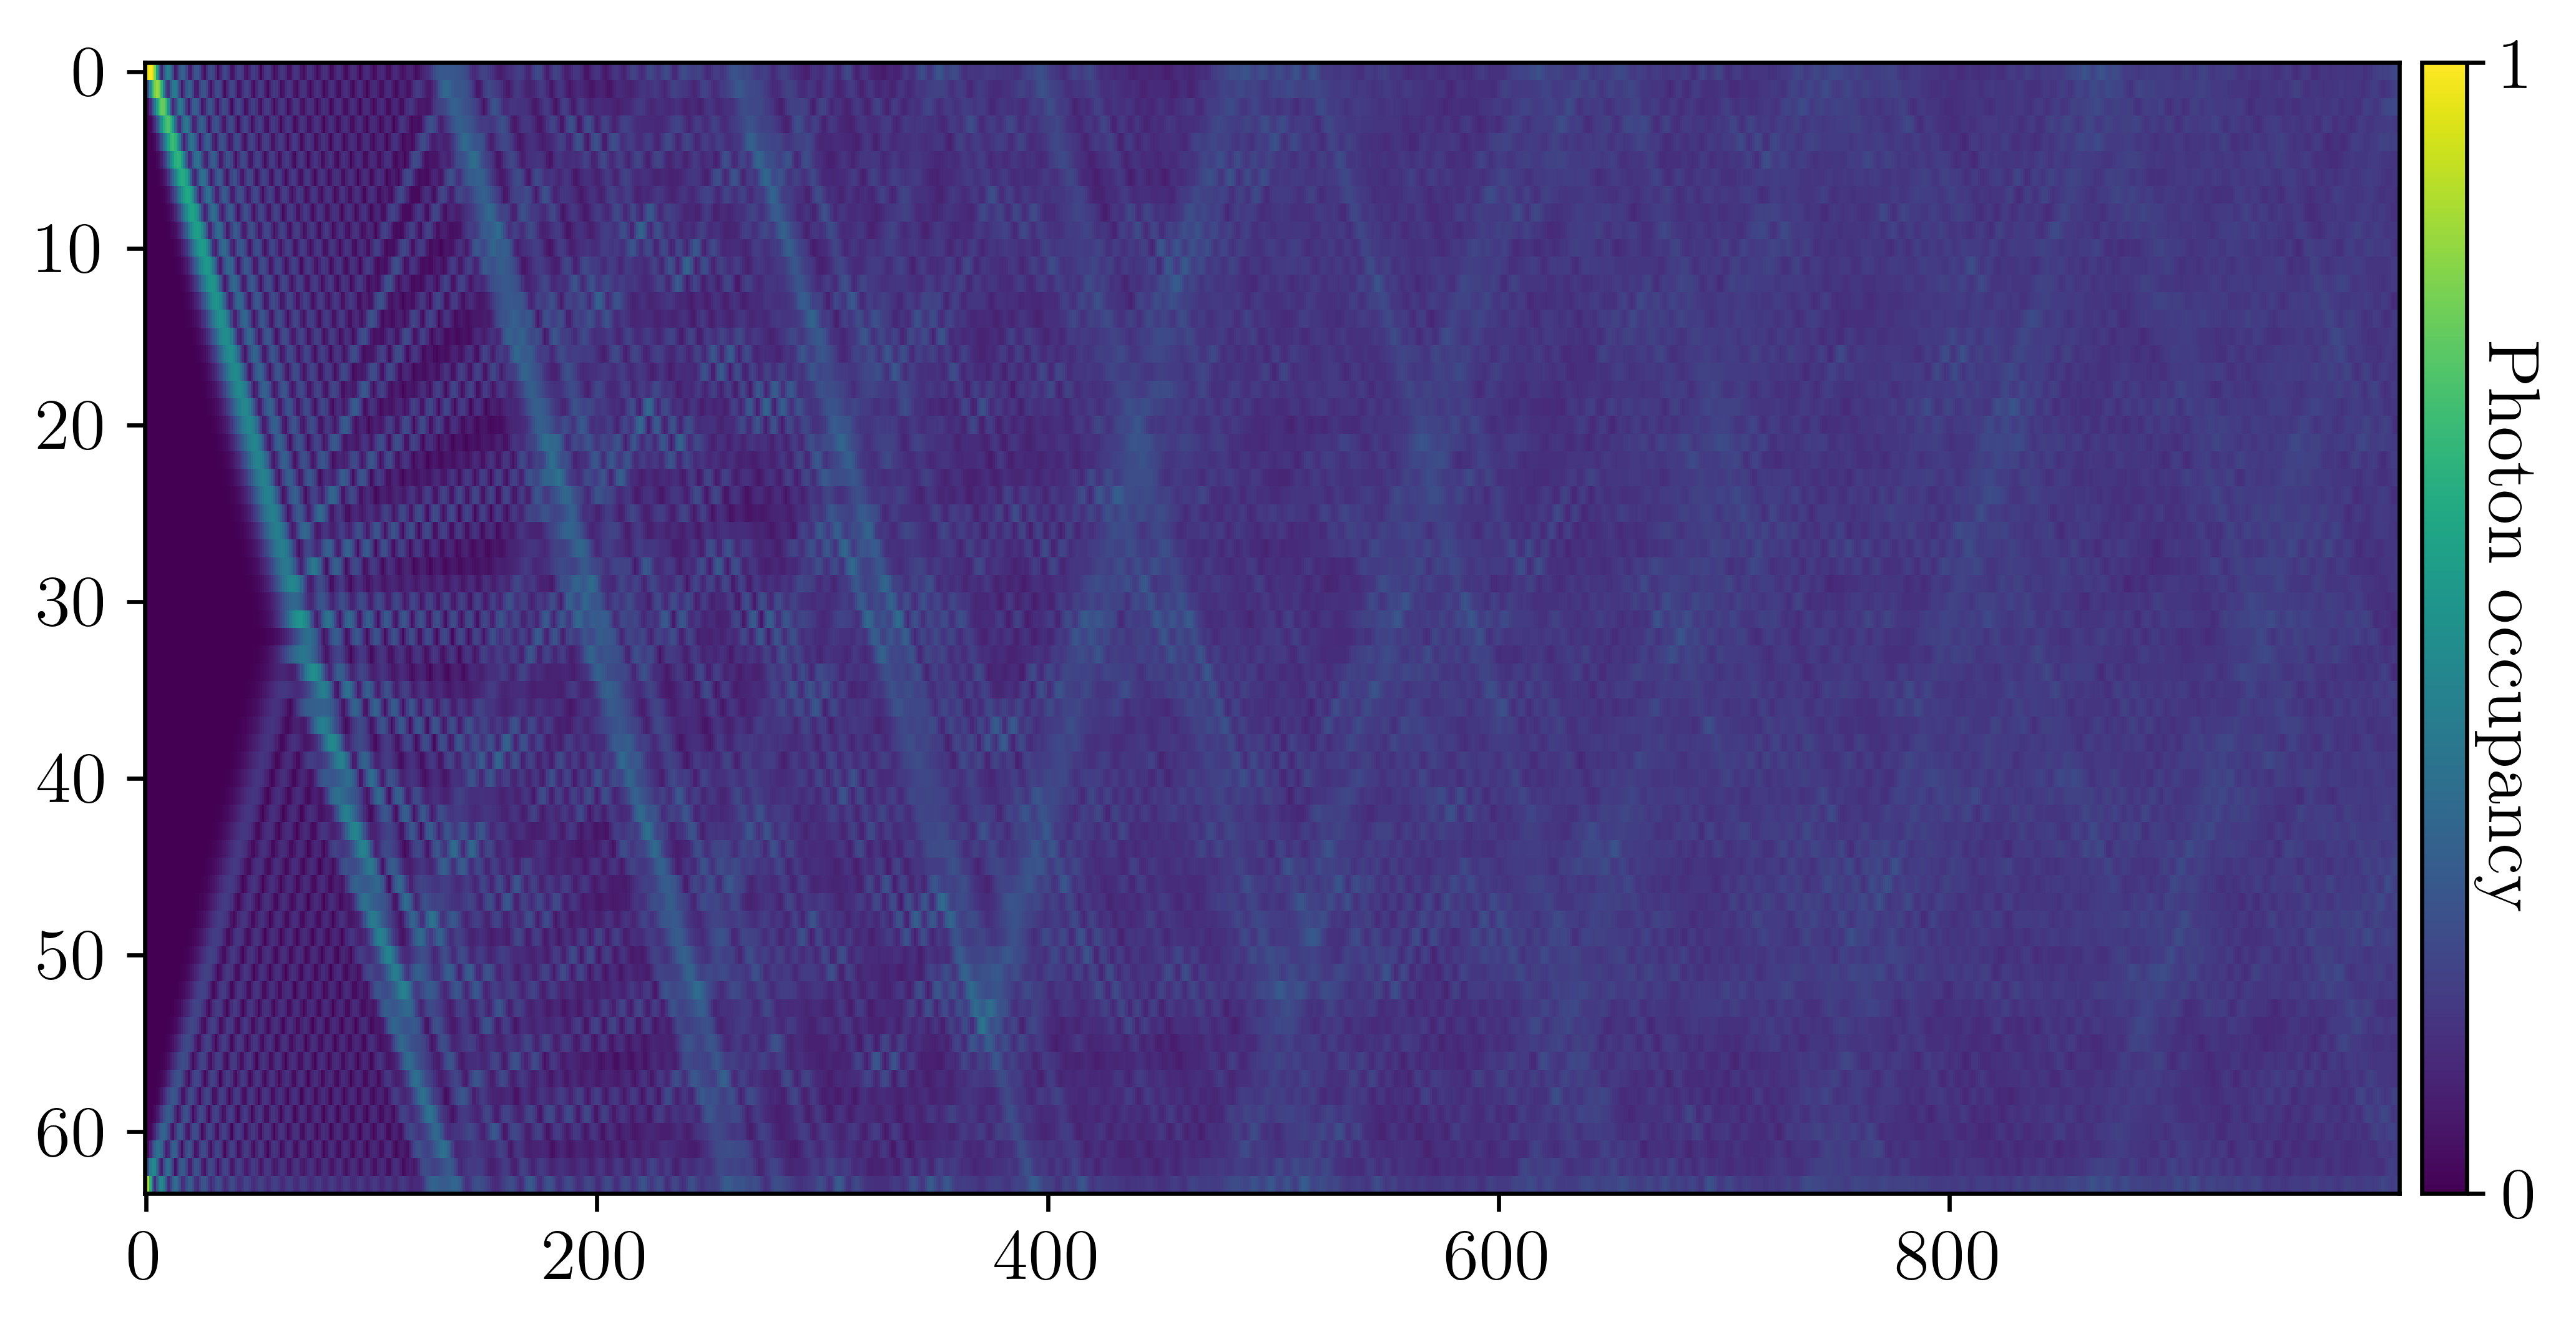

In [32]:
def plot_1d_state_evolution(photon_expectations_over_time, take_sqrt_of_amplitudes=False):
    
    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('font', size=14)

    fig, ax = plt.subplots(1,1, figsize=(8,4))

    # Plot state over training
    cmap=plt.get_cmap('viridis')
    # cmap=plt.get_cmap('plasma')
    
    if take_sqrt_of_amplitudes:
        ax.imshow(np.sqrt(np.transpose(photon_expectations_over_time)), aspect='auto', cmap=cmap)
    else:
        ax.imshow(np.transpose(photon_expectations_over_time), aspect='auto', cmap=cmap)
    # ax.set_xticks([])
    # ax.yaxis.set_major_locator(plt.IndexLocator(base=1, offset=0.35))
    # ax.yaxis.set_ticks_position('none')
    # ax.set_yticklabels(kets)
    # ax.tick_params(axis = 'y', labelsize = 10, pad = 0)
    
    # Add a colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size = '2%', pad = '1%')
    cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap,
                                     norm = mpl.colors.Normalize(0, 1),
                                     ticks = [0, 1])
    cax.get_yaxis().labelpad=0
    cax.set_ylabel("Photon occupancy", rotation=270)
    cax.set_yticklabels(["$0$", "$1$"])
    
    return fig, ax, cax

plot_1d_state_evolution(photon_expectations_over_time, take_sqrt_of_amplitudes=True)
plt.savefig("1d_evolution_toroidal.pdf", dpi=300, bbox_inches='tight', pad_inches=0)


## Plot code copied from other places

In [ ]:
def plot_frames(filepath, num_qubits=N, num_epochs=None):
    
    f = h5py.File(filepath, 'r')
    
    fidelities_train = np.array(f['fidelities_train'])
    fidelities_val = np.array(f['fidelities_val'])
    operators = np.array(f['operators'])
    
    num_epochs = len(fidelities_train) if num_epochs is None else num_epochs

    operator_targ = extract_operator_from_circuit(QFT, num_qubits)
    kets, bras = computational_basis_labels(num_qubits, include_bras=True)
    
    for i in pbar(range(num_epochs)):
        
        global_phase = np.mean(np.angle(operators[i]/operator_targ))
        operator = operators[i] / np.exp(1j * global_phase)

        # Make figure and axis layout
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        fig = plt.figure(figsize=(12,9), tight_layout=True)
        gs = mpl.gridspec.GridSpec(2, 2, height_ratios = [2, 1])

        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])

        # Plot operator visualizations
        hinton(operator, xlabels=kets, ylabels=bras, fig=fig, ax=ax1, title="$\\tilde{U}$")
        hinton(operator_targ, xlabels=kets, ylabels=bras, fig=fig, ax=ax2, title="$\hat{U}$")

        # Plot antifidelity
        fidel_val = fidelities_val[0:i]
        fidel_train = fidelities_train[0:i]
        ax_bot = fig.add_subplot(gs[1, :])
        loss_plot(fidel_val, fidel_train, x_units='iterations', x_max = num_epochs, fig=fig, ax=ax_bot)

        # Save frame
        title = str(i).zfill(4)
        plt.savefig("assets/frames/qft_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

In [ ]:
def matrix_histogram(M, xlabels=None, ylabels=None, title=None, limits=None,
                     colorbar=True, fig=None, ax=None):
    """
    Draw a histogram for the matrix M, with the given x and y labels and title.

    Parameters
    ----------
    M : Matrix of Qobj
        The matrix to visualize

    xlabels : list of strings
        list of x labels

    ylabels : list of strings
        list of y labels

    title : string
        title of the plot (optional)

    limits : list/array with two float numbers
        The z-axis limits [min, max] (optional)

    ax : a matplotlib axes instance
        The axes context in which the plot will be drawn.

    Returns
    -------
    fig, ax : tuple
        A tuple of the matplotlib figure and axes instances used to produce
        the figure.

    Raises
    ------
    ValueError
        Input argument is not valid.

    """

    if isinstance(M, Qobj):
        # extract matrix data from Qobj
        M = M.full()

    n = np.size(M)
    xpos, ypos = np.meshgrid(range(M.shape[0]), range(M.shape[1]))
    xpos = xpos.T.flatten() - 0.5
    ypos = ypos.T.flatten() - 0.5
    zpos = np.zeros(n)
    dx = dy = 0.8 * np.ones(n)
    dz = np.real(M.flatten())

    if isinstance(limits, list) and len(limits) == 2:
        z_min = limits[0]
        z_max = limits[1]
    else:
        z_min = min(dz)
        z_max = max(dz)
        if z_min == z_max:
            z_min -= 0.1
            z_max += 0.1

    norm = mpl.colors.Normalize(z_min, z_max)
    cmap = cm.get_cmap('jet')  # Spectral
    colors = cmap(norm(dz))

    if ax is None:
        fig = plt.figure()
        ax = _axes3D(fig, azim=-35, elev=35)

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors)

    if title and fig:
        ax.set_title(title)

    # x axis
    xtics = -0.5 + np.arange(M.shape[0])
    ax.axes.w_xaxis.set_major_locator(plt.FixedLocator(xtics))
    if xlabels:
        nxlabels = len(xlabels)
        if nxlabels != len(xtics):
            raise ValueError(f"got {nxlabels} xlabels but needed {len(xtics)}")
        ax.set_xticklabels(xlabels)
    ax.tick_params(axis='x', labelsize=14)

    # y axis
    ytics = -0.5 + np.arange(M.shape[1])
    ax.axes.w_yaxis.set_major_locator(plt.FixedLocator(ytics))
    if ylabels:
        nylabels = len(ylabels)
        if nylabels != len(ytics):
            raise ValueError(f"got {nylabels} ylabels but needed {len(ytics)}")
        ax.set_yticklabels(ylabels)
    ax.tick_params(axis='y', labelsize=14)

    # z axis
    ax.axes.w_zaxis.set_major_locator(plt.IndexLocator(1, 0.5))
    ax.set_zlim3d([min(z_min, 0), z_max])

    # color axis
    if colorbar:
        cax, kw = mpl.colorbar.make_axes(ax, shrink=.75, pad=.0)
        mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)

    return fig, ax

In [ ]:
def plot_qft_figure(filepath, t1 = 0, t2 = 25, tmax = 50, figscale = 12, savefig = False):

    f = h5py.File(filepath, 'r')

    fidelities_train = np.array(f['fidelities_train'])
    fidelities_val = np.array(f['fidelities_val'])
    operators = np.array(f['operators'])
    fidelity_init = 1 - np.array(f['fidelity_initial'])[-1]
    operator_init = np.array(f['operator_initial'])
    
    fidelities_val = np.insert(fidelities_val, 0, fidelity_init, axis=0)
    fidelities_train = np.insert(fidelities_train, 0, fidelity_init, axis=0)
    operators = np.insert(operators, 0, operator_init, axis=0)
    
    operator_targ = extract_operator_from_circuit(QFT, N)
    kets, bras = computational_basis_labels(N, include_bras=True)

    global_phase1 = np.mean(np.angle(operators[t1]/operator_targ))
    operator1 = operators[t1] / np.exp(1j * global_phase1)

    global_phase2 = np.mean(np.angle(operators[t2]/operator_targ))
    operator2 = operators[t2] / np.exp(1j * global_phase2)
    
    global_phase3 = np.mean(np.angle(operators[tmax]/operator_targ))
    operator3 = operators[tmax] / np.exp(1j * global_phase3)

    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    fig = plt.figure(figsize=(figscale, figscale*(1/3 + 1/6)), tight_layout=True)
    gs = mpl.gridspec.GridSpec(2, 3, height_ratios = [2, 1])

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Plot antifidelity
    fidel_val = fidelities_val[0:tmax+1]
    fidel_train = fidelities_train[0:tmax+1]
    ax_bot = fig.add_subplot(gs[1, :])
    loss_plot(fidel_val, fidel_train, x_units='epochs', x_max = tmax+1, fig=fig, ax=ax_bot, log_fidelity=False)

    # Plot operator visualizations
    fidel1 = fidel_val[t1]
    hinton(operator1, xlabels=kets, ylabels=bras, fig=fig, ax=ax1, title="$\\tilde{U}_{"+str(t1)+"}$")
    
    fidel2 = fidel_val[t2]
    hinton(operator2, xlabels=kets, ylabels=bras, fig=fig, ax=ax2, title="$\\tilde{U}_{"+str(t2)+"}$")
    
    fidel_3 = fidel_val[tmax]
    hinton(operator3, xlabels=kets, ylabels=bras, fig=fig, ax=ax3, title="$\\tilde{U}_{"+str(tmax)+"}$")

    if savefig:
        plt.savefig("assets/qft_3panel.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
    else:
        plt.show()
    
plot_qft_figure('logs/operator_history_4_qubits_2019.08.27.11.03.16.h5', t1=10, t2=20, tmax=50, savefig=False)

## Scratch work

In [85]:
N = 2
a1 = qt.tensor([qt.destroy(N), qt.qeye(N)])
a2 = qt.tensor([qt.qeye(N), qt.destroy(N)])
II = qt.tensor([qt.qeye(N), qt.qeye(N)])
(1j * np.pi/16 * np.exp(1j*np.pi/4) * (a1.dag() * a2 + a1 * a2.dag())).expm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.99993807-0.01927649j -0.13794625+0.13973049j
   0.        +0.j        ]
 [ 0.        +0.j         -0.13794625+0.13973049j  0.99993807-0.01927649j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   1.        +0.j        ]]

In [86]:
(1j*np.pi/16 * np.exp(1j*np.pi/4) * (a1.dag() * a2 + a1 * a2.dag())) + II

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j         -0.13884009+0.13884009j
   0.        +0.j        ]
 [ 0.        +0.j         -0.13884009+0.13884009j  1.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   1.        +0.j        ]]

In [96]:
(1j * np.pi/16 * np.exp(1j*np.pi/4) * (a1.dag() * a2 + a1 * a2.dag())).expm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.99993807-0.01927649j -0.13794625+0.13973049j
   0.        +0.j        ]
 [ 0.        +0.j         -0.13794625+0.13973049j  0.99993807-0.01927649j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   1.        +0.j        ]]

In [95]:
(1j * np.pi/16 * (a1.dag() * a2 + a1 * a2.dag())).expm() * np.exp(1j*np.pi/4)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[2.19328005+0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         2.15113679+0.j         0.        +0.42788771j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.42788771j 2.15113679+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  2.19328005+0.j        ]]

In [105]:
(1j * np.pi/4 * (a1.dag() * a2 + a1 * a2.dag())).expm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.70710678+0.j         0.        +0.70710678j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.70710678j 0.70710678+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  1.        +0.j        ]]

In [107]:
(1j * np.pi/4 * (np.exp(-1j*np.pi/4)*a1.dag() * a2 + np.exp(1j*np.pi/4) * a1 * a2.dag())).expm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j   0.        +0.j   0.        +0.j   0.        +0.j ]
 [ 0.        +0.j   0.70710678+0.j  -0.5       +0.5j  0.        +0.j ]
 [ 0.        +0.j   0.5       +0.5j  0.70710678+0.j   0.        +0.j ]
 [ 0.        +0.j   0.        +0.j   0.        +0.j   1.        +0.j ]]